# 3a) Training a GAN to generate 10 new items

**Using pytorch DCGAN example as a reference**

**Imports and setting up the manual seed:**

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from torchvision.utils import make_grid

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
workers = 2 # Number of workers for dataloader
batch_size = 128

# Spatial size of training images. All images will be resized to this
image_size = 28
image_size_flat = 784 # 28 x 28
latent_space_size = 100

num_epochs = 20
lr = 2e-4

**Loading the dataset:**

In [3]:
#directory for dataset
dataroot = '~/.pytorch/F_MNIST_data'
# Create the dataset
dataset = datasets.FashionMNIST(root=dataroot,
                           download=True,
                           train=True, 
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [4]:
real_batch = next(iter(dataloader))
np.shape(real_batch[0].to(device)[0])

torch.Size([1, 28, 28])

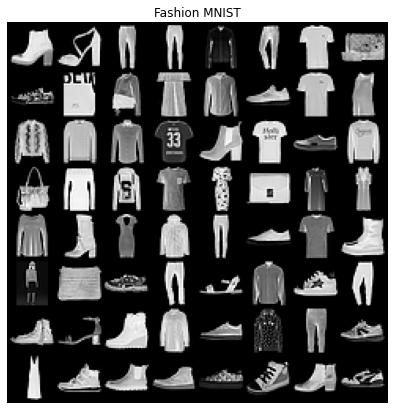

In [5]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Fashion MNIST")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# Custom weights for modules' initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.2)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.2)
        nn.init.constant_(m.bias.data, 0)

**Defining models:**

In [7]:
# Generator Model
# transpose2d output size: (W-1)*S - 2p + K
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # sample_size => 784
        self.fc = nn.Sequential(
            nn.Linear(latent_space_size, 784),
            nn.BatchNorm1d(784),
            nn.ReLU(True))

        # 28*28 = 784 => 16 x 7 x 7 => 32 x 14 x 14 => 1 x 28 x 28
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
            )


    def forward(self, batch_size: int):
        # Generate random noise as an input
        noise = torch.randn(batch_size, latent_space_size).to(device)
        # Use transposed convolutions for generator since we go from flat to image size
        x = self.fc(noise)
        x = x.reshape(-1,16,7,7)
        x = self.conv(x)
        return x

In [8]:
# Create the generator
modelG = Generator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda'):
    modelG = nn.DataParallel(modelG, list(range(1)))

# Apply the weights_init function to randomly initialize all weights
modelG.apply(weights_init)

# Print the model
print(modelG)

DataParallel(
  (module): Generator(
    (fc): Sequential(
      (0): Linear(in_features=100, out_features=784, bias=True)
      (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv): Sequential(
      (0): ConvTranspose2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (4): Tanh()
    )
  )
)


In [9]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 1 x 28 x 28 => 32 x 14 x 14 => 16 x 7 x 7 => 784 = 1 x 28 x 28
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 16, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 784),
            nn.BatchNorm1d(784),
            nn.Sigmoid(),
            nn.Linear(784, 1),
            nn.Sigmoid(),
            )

    def forward(self, images: torch.Tensor, targets: torch.Tensor):

        x = self.conv(images)
        prediction = self.fc(x)

        #loss = F.binary_cross_entropy_with_logits(prediction, targets)
        return prediction

In [10]:
# Create the Discriminator
modelD = Discriminator()

# Handle multi-gpu if desired
if (device.type == 'cuda'):
    modelD = nn.DataParallel(modelD, list(range(1)))

# Apply the weights_init function to randomly initialize all weights
modelD.apply(weights_init)

# Print the model
print(modelD)

DataParallel(
  (module): Discriminator(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (fc): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=784, bias=True)
      (2): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Sigmoid()
      (4): Linear(in_features=784, out_features=1, bias=True)
      (5): Sigmoid()
    )
  )
)


**Optimizers for both generator and discriminator:**

In [11]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(params=modelD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(params=modelG.parameters(), lr=lr, betas=(0.5, 0.999))

**Training the DCGAN...**

In [12]:

# Real and fake labels
real_targets = torch.ones(batch_size, 1, dtype=torch.float, device=device)
fake_targets = torch.zeros(batch_size, 1, dtype=torch.float, device=device )


# Training loop

for epoch in range(num_epochs):

    d_losses, g_losses = [],[]

    for images, labels in tqdm(dataloader):

        ############################
        # Discriminator training
        # maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        modelD.zero_grad()
        # forward pass the real batch through discriminator
        realD = modelD(images.to(device), real_targets)
        lossD_real = criterion(realD,real_targets)
        # calculate gradients
        lossD_real.backward()

        # now generate batch of latent vectors
        fake = modelG(batch_size).to(device)
        # classify fake generated images with discriminator now
        # and pass the loss
        fakeD = modelD(fake.detach(), fake_targets)
        lossD_fake = criterion(fakeD,fake_targets)
        #calculate gradients for fake ones now
        lossD_fake.backward()
        # complete error of discriminator over fake and real images
        errorD = lossD_real + lossD_fake

        optimizerD.step()

        ############################
        # Generator Network Training
        # maximize log(D(G(z)))
        ###########################

        modelG.zero_grad()
        # pass fake images to discriminator and calculate the loss
        realG = modelD(fake.to(device), real_targets)
        lossG_real = criterion(realG,real_targets)
        # calculate gradients
        lossG_real.backward()
        
        optimizerG.step()

        # Keep losses for logging
        d_losses.append(errorD.item())
        g_losses.append(lossG_real.item())


    # Print average losses for both generator and discriminator
    print()
    print(f" epoch {epoch}, Discriminator Loss: {np.mean(d_losses)}, Generator Loss: {np.mean(g_losses)}")
    print()


100%|██████████| 468/468 [00:23<00:00, 20.07it/s]



 epoch 0, Discriminator Loss: 0.9795463266026261, Generator Loss: 1.0020716996529164



100%|██████████| 468/468 [00:14<00:00, 32.40it/s]



 epoch 1, Discriminator Loss: 0.4604241151967619, Generator Loss: 1.698813988866969



100%|██████████| 468/468 [00:14<00:00, 32.44it/s]



 epoch 2, Discriminator Loss: 0.3558956123570092, Generator Loss: 2.1633217635317745



100%|██████████| 468/468 [00:14<00:00, 31.52it/s]



 epoch 3, Discriminator Loss: 0.43422312455044854, Generator Loss: 2.053494733113509



100%|██████████| 468/468 [00:14<00:00, 32.55it/s]



 epoch 4, Discriminator Loss: 0.4396882846187323, Generator Loss: 2.0800045680286536



100%|██████████| 468/468 [00:15<00:00, 30.79it/s]



 epoch 5, Discriminator Loss: 0.4131246807101445, Generator Loss: 2.167262921985398



100%|██████████| 468/468 [00:14<00:00, 32.06it/s]



 epoch 6, Discriminator Loss: 0.39492921066335124, Generator Loss: 2.256977522220367



100%|██████████| 468/468 [00:14<00:00, 32.55it/s]



 epoch 7, Discriminator Loss: 0.3970665461741961, Generator Loss: 2.3085852616872544



100%|██████████| 468/468 [00:14<00:00, 32.51it/s]



 epoch 8, Discriminator Loss: 0.3970125961380127, Generator Loss: 2.3454405043879127



100%|██████████| 468/468 [00:14<00:00, 32.75it/s]



 epoch 9, Discriminator Loss: 0.3887308876101787, Generator Loss: 2.3961850593232703



100%|██████████| 468/468 [00:14<00:00, 32.23it/s]



 epoch 10, Discriminator Loss: 0.38925466902999795, Generator Loss: 2.434196126766694



100%|██████████| 468/468 [00:14<00:00, 32.42it/s]



 epoch 11, Discriminator Loss: 0.38133363578564083, Generator Loss: 2.488456128499447



100%|██████████| 468/468 [00:14<00:00, 32.30it/s]



 epoch 12, Discriminator Loss: 0.3757379497600417, Generator Loss: 2.5365878893778873



100%|██████████| 468/468 [00:14<00:00, 32.23it/s]



 epoch 13, Discriminator Loss: 0.36111680666605633, Generator Loss: 2.5889192289776273



100%|██████████| 468/468 [00:14<00:00, 32.54it/s]



 epoch 14, Discriminator Loss: 0.3536201927205946, Generator Loss: 2.639748298204862



100%|██████████| 468/468 [00:14<00:00, 32.58it/s]



 epoch 15, Discriminator Loss: 0.34452531926142865, Generator Loss: 2.7072096390601916



100%|██████████| 468/468 [00:14<00:00, 32.17it/s]



 epoch 16, Discriminator Loss: 0.3328986027174526, Generator Loss: 2.775565102059617



100%|██████████| 468/468 [00:14<00:00, 31.92it/s]



 epoch 17, Discriminator Loss: 0.3240331669903209, Generator Loss: 2.835928463528299



100%|██████████| 468/468 [00:15<00:00, 30.02it/s]



 epoch 18, Discriminator Loss: 0.3105831845448567, Generator Loss: 2.8881762012457237



100%|██████████| 468/468 [00:14<00:00, 31.93it/s]


 epoch 19, Discriminator Loss: 0.3090280691145832, Generator Loss: 2.948804142128708



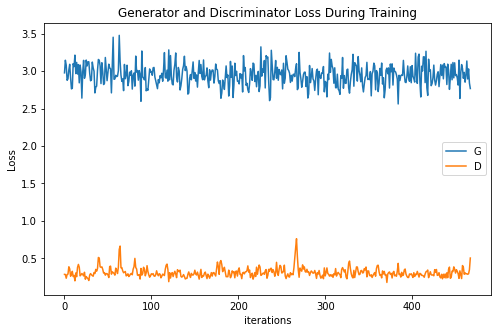

In [13]:
plt.figure(figsize=(8,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Generate new samples with DCGAN:

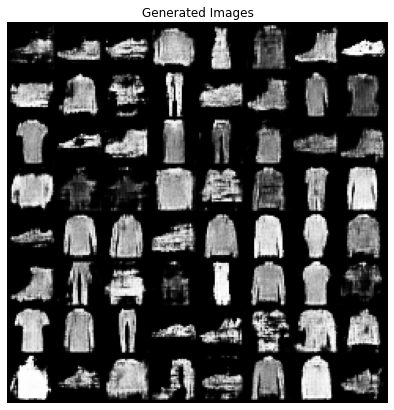

In [14]:
# Plot some generated images
DCGAN_image = modelG(batch_size).detach()
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(DCGAN_image.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))